# Settling Time After a Slew

This notebook evaluates the RMS of displacement values against long-term position and rotation measurements taken by the IMS at M1M3. It returns the settling time determined by when the values of the IMS measurement with respect to its long term behavior (determined by the parameter postPadding in seconds after the slew stop) becomes compatible with the standard deviation, using a chi2 test, or whenever the RMS or bias become sufficiently small with respect to the requirement.

Note that in this version of the notebook, you will have to introduce the dayObs and slew of interest to be analyzed.

[LVV-T11258]: https://jira.lsstcorp.org/browse/LVV-11258

### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from scipy import stats

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst.summit.utils.blockUtils import BlockParser

import warnings

warnings.filterwarnings("ignore")

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [4]:
req_delta_t = 1.0  ## seconds after slew
req_rms_position = (
    2e-3  ## mm, tolerance from repeatability requirement for IMS positional
)
req_rms_rotation = (
    3e-5  ## degrees, tolerance from repeatability requirement for IMS rotational
)

#### Observation day

In [5]:
## Insert here the dayObs of interest
dayObs = 20231129  # 20231122

#### Reference time (padding after slew)

In [6]:
# define time padding after end of slew
postPadding = 15  # in seconds, integration time will be 30 s

#### Define column names

In [7]:
## Define column names
all_columns = [
    "xPosition",
    "yPosition",
    "zPosition",
    "xRotation",
    "yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

### Define functions

#### measure settling time

This is the function that will return the number of seconds it takes for the queried IMS value to settle, using a chi2 test of bias vs long term value.

In [34]:
def computeSettleTime(
    df_ims,  # input data frame
    referenceTime="2023-06-01T06:00:0Z",  # time for slew stop (T0)
    lo_delta_t=5,  # in seconds
    hi_delta_t=30,  # in seconds
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    req_delta_t=3,  # time for settling, in seconds
    chi2prob=0.999,  # confidence level for IMS variable wrt to long term value and variance to agree
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.0001
    else:
        print("Unidentified column")
        return -1

    settleTime = False

    # T0 and T1 defines the window for requirement to be met
    T0 = pd.to_datetime(referenceTime)  # this is slew stop
    T1 = T0 + pd.to_timedelta(
        req_delta_t, unit="s"
    )  # this is the end of maximum req. window
    delta_window = [
        pd.Timedelta(lo_delta_t, "seconds"),
        pd.Timedelta(hi_delta_t, "seconds"),
    ]
    # zoom around the T0 of interest
    TZoom = [T0 - delta_window[0], T0 + delta_window[1]]

    # targetVariablePlot takes the data frame for the complete plot range
    targetVariablePlot = df_ims[imsColumn][TZoom[0] : TZoom[1]]
    # targetVariableCheck takes the data from the slew stop, until the end of the plot
    targetVariableCheck = df_ims[imsColumn][T0 : TZoom[1]]
    # targetVariableWindow takes the data from the slew stop, until the end of requirement window
    targetVariableWindow = df_ims[imsColumn][T0:T1]
    idxT0 = df_ims.index[  # index in dataframe closest in time to slew stop
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = (
        df_ims.index[  # index in dataframe closest in time to end of requirement window
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
        ]
    )
    idxTend = df_ims.index[  # index in dataframe closest in time to end of plot
        df_ims.index.get_indexer(
            [pd.to_datetime(T0 + delta_window[1])], method="nearest"
        )
    ]
    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxTend]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1

    # it is important that the end of the plot (targetVariableReference[1])
    # does not hit another slew or movement, nor at any point in the middle of the window

    # correct IMS variable wrt end of plot
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]
    correctedVariableCheck = targetVariableCheck - targetVariableReference[1]
    correctedVariableCheck2 = np.square(correctedVariableCheck)

    # number of values where the chi2 will be computed
    rolling = 10  # 50 is approx. 1 s
    # chi2 right tail probability for N=rolling dof at chi2prob CL
    crit = stats.chi2.ppf(chi2prob, rolling)

    rms = correctedVariableCheck.rolling(rolling).std()
    var = correctedVariableCheck.rolling(rolling).var()
    mean = abs(correctedVariableCheck.rolling(rolling).mean())

    # compute the chi2 against the null hypothesis
    # the x_i are the measurements in a window (wrt to reference at end of plot)
    # the variance is for the same values
    # so chi2 = sum_N[(x_i - 0)**2/variance] where N = rolling
    sum2 = correctedVariableCheck2.rolling(rolling).sum()
    chi2 = sum2 / var
    # check the chi2 at each step using rollingCheck as the number of consecutive instances in which
    # chi2 has to be under the critical value
    # or rms and bias be both already 10% of requirement
    PFCheck = (chi2 < crit) | ((rms < 0.1 * rmsReq) & (mean < 0.1 * rmsReq))
    # PFCheck = (rms < 0.2 * rmsReq) & (mean < 0.5 * rmsReq)
    rollingCheck = 10
    stabilityCheck = (
        PFCheck.rolling(rollingCheck).apply(lambda s: s.all()) > 0
    )  # true if rollingCheck consecutive true values of PFcheck
    if len(stabilityCheck[stabilityCheck == True]) < rollingCheck:  ## == 0:
        # print(f"Not settled within {postPadding} s window")
        settleTime = False
    elif rms[stabilityCheck[stabilityCheck == True].index[0]] <= rmsReq:
        settleTime = stabilityCheck[stabilityCheck == True].index[rollingCheck]
    else:
        n = 1
        while (
            rms[stabilityCheck[stabilityCheck == True].index[n + rollingCheck]] > rmsReq
        ):
            settleTime = stabilityCheck[stabilityCheck == True].index[n + rollingCheck]
            n = n + 1
        # if settleTime < referenceTime:
        #    settleTime = referenceTime
    settleInterval = -1
    if settleTime:
        settleInterval = settleTime - referenceTime
        if settleInterval.total_seconds() < 0:
            print(f"Already settled at slew stop")
            settleInterval = 0
        else:
            settleInterval = settleInterval.total_seconds()

    title = imsColumn
    fig = plt.figure()
    label = "Corrected " + imsColumn + "(" + units + ") difference wrt end of plot"
    plt.plot(
        correctedVariablePlot,
        color="red",
        ls="dashed",
        lw="0.5",
        label=label,
    )
    plt.plot(rms, label=f"RMS of corrected value, using {rolling} rolling values")
    plt.plot(
        mean,
        ls="dashed",
        label=f"Bias of corrected value, using {rolling} rolling values",
    )
    if settleTime:
        plt.arrow(
            settleTime,
            1.1 * rmsReq,
            0.0,
            -0.5 * rmsReq,
            width=2e-6,
            head_length=0.5 * rmsReq,
        )
        plt.text(
            0.5,
            0.92,
            "Settle time =" + " {:.2f} ".format(settleInterval) + " s",
            transform=fig.transFigure,
        )
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label="Slew stop")
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label="IMS repeatability req.")
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.xlabel("Time [UTC]")
    plt.ylabel(f"{imsColumn} {units}")
    plt.ylim(-ylimMax, ylimMax)
    fig.autofmt_xdate()
    plt.legend(loc="upper right", fontsize="8")
    fig.tight_layout()

    if not settleTime:
        return -1

    return settleInterval

#### compare IMS vs mount data

This is an auxiliary function to plot information from the IMS with respect to the elevation and azimuth measurements from the mount.

In [9]:
def compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    referenceTime="2023-06-01 06:53:37.326",
    lo_delta_t=5,  # in seconds
    hi_delta_t=60,  # in seconds
):
    fig, axs = plt.subplots(5, 1, dpi=125, figsize=(6, 8))
    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(
        lo_delta_t, unit="s"
    )  ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(referenceTime) + pd.to_timedelta(hi_delta_t, unit="s")

    ax = axs[0]
    actpos_ele = df_mtmount_ele["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_ele, color="red", lw="0.5")
    ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k")
    ax.set_ylabel("Elevation \nPosition\n[deg]")

    ax = axs[1]
    actpos_azi = df_mtmount_azi["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_azi, color="red", lw="0.5")
    ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k", label="Slew stop")
    ax.set_ylabel("Azimuth \nPosition\n[deg]")

    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(lo_delta_t, unit="s")
    t_end_plot = pd.to_datetime(referenceTime) + pd.to_timedelta(hi_delta_t, unit="s")

    plotstring = ["xPosition", "yPosition", "zPosition"]
    plotrange = np.arange(len(plotstring))
    for i in plotrange:
        ax = axs[i + 2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos, color="red", lw="0.5")
        ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k")
        ax.set_ylabel(plotstring[i] + " \n[mm]")
    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(referenceTime)
    fig.legend()
    fig.tight_layout()
    ### TBD: use a delta time wrt slew stop in x-label

### Load data

#### Get slew stops

In [10]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type == TMAState.SLEWING]
tracks = [e for e in events if e.type == TMAState.TRACKING]
print(f"Found {len(slews)} slews and {len(tracks)} tracks")

Found 492 slews and 378 tracks


In [12]:
# Get events related to soak tests (block 137 currently)
block137Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 137
    blockNums = {b.blockNumber for b in blockInfos}
    if 137 in blockNums:
        block137Events.append(event)

print(f"Of the {len(events)} events, {len(block137Events)} relate to block 137.")

Of the 870 events, 750 relate to block 137.


In [14]:
# Print out sequential number of events that have certain characteristics
s = 0
for i in range(len(block137Events)):
    if (
        block137Events[i].endReason == TMAState.TRACKING
        and block137Events[i].type == TMAState.SLEWING
    ):
        s = s + 1
        print(block137Events[i].seqNum, end=", ")

11, 13, 15, 17, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 118, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 363, 370, 372, 374, 377, 385, 395, 397, 399, 401, 403, 405, 407, 409, 411, 413, 415, 417, 419, 421, 423, 425, 427, 429, 431, 433, 435, 437, 439, 441, 443, 446, 448, 450, 452, 454, 456, 458, 460, 462, 464, 466, 468, 470, 472, 474, 476, 478, 480, 482, 484, 486, 488, 490, 492, 494, 496, 498, 500, 502, 504, 506, 508, 510, 512, 514, 516, 518, 520, 522, 52

In [26]:
targetSeqNum = 290

In [27]:
# find the appropriate slews index that has the sequential number selected above
for s, sl in enumerate(slews):
    if sl.seqNum == targetSeqNum:
        i_slew = s
        break
print(f"Event with seqNum {targetSeqNum} corresponds to slew number {i_slew}")

Event with seqNum 290 corresponds to slew number 185


In [28]:
t0 = Time(slews[i_slew].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(slews[i_slew].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
print("Slew stop at:", t1)

# Get IMS data

df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=slews[i_slew], postPadding=postPadding
)
df_ims = df_ims[all_columns]
# Convert meter to milimeter
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

Slew stop at: 2023-11-30 02:41:57.264000+00:00


In [29]:
# Get mount data
df_mtmount_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", event=slews[i_slew], postPadding=postPadding
)
df_mtmount_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", event=slews[i_slew], postPadding=postPadding
)

### Look at data

This step is not necessary, but useful to get a visual impression of how the IMS data vary with TMA movements.

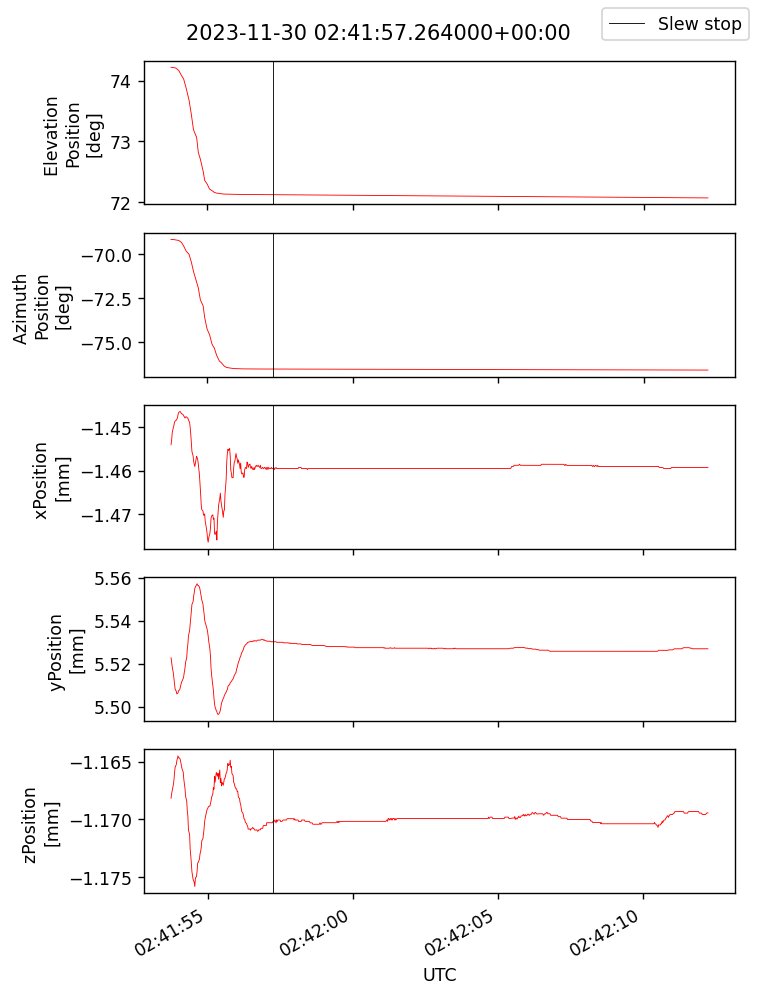

In [30]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t1,
    10,
    pd.to_timedelta(postPadding, unit="s"),
)

### Run test

Currently the test involves executing the computeSettleTime function. The test will return the settle time determined by a chi square test under a certain probability (default is 0.999) that the IMS variable fluctuactions with respect to the value at postPadding seconds after slew stop is compatible with the RMS of the variable itself. Also, it is required that the RMS is below the IMS requirement for position or rotation.

xPosition settled in 14.10 s
yPosition settled in 6.34 s
zPosition settled in 9.26 s
xRotation not settled in 15 s
yRotation settled in 0.98 s
zRotation settled in 0.70 s
Average settling time is 6.28 s


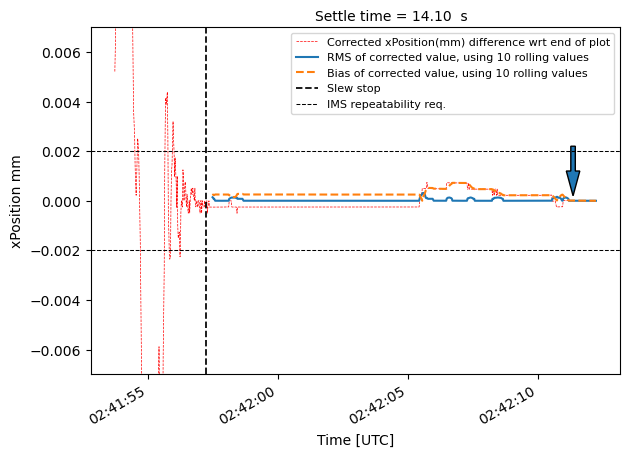

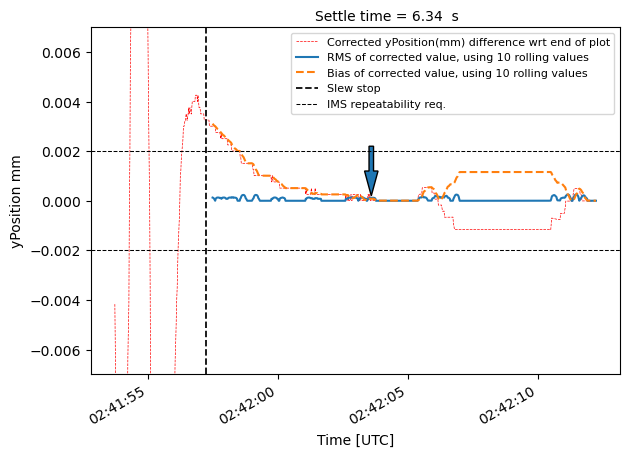

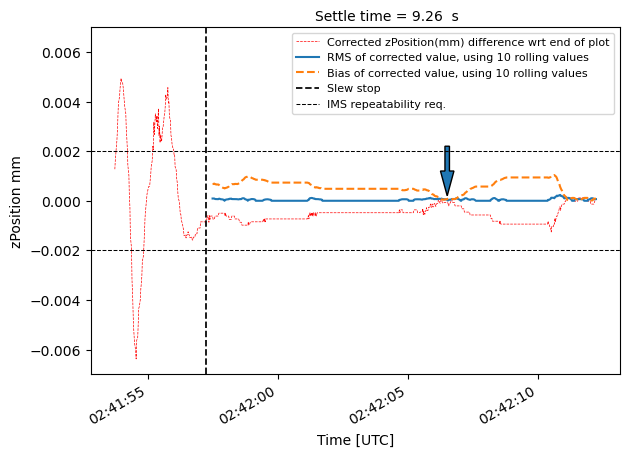

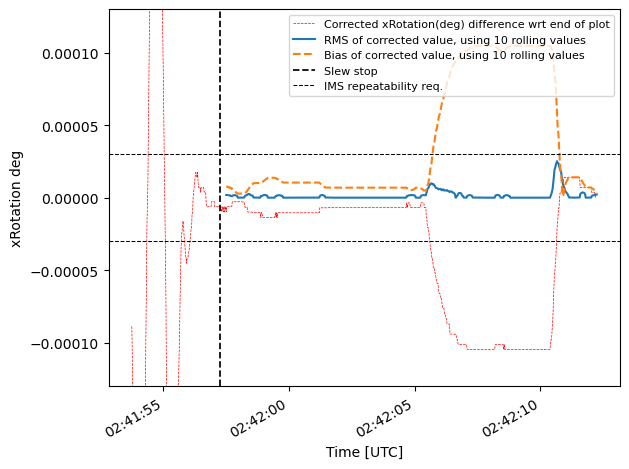

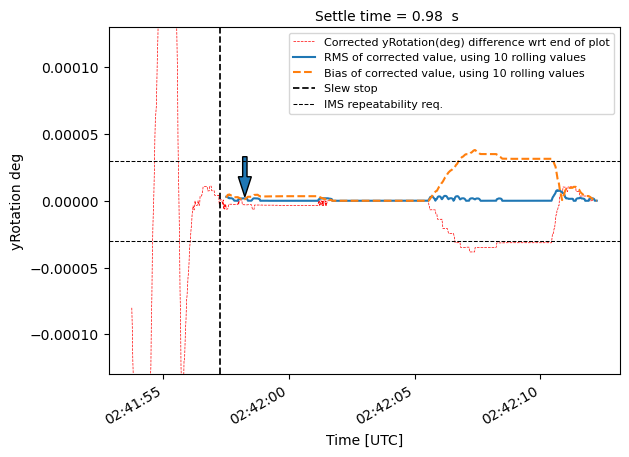

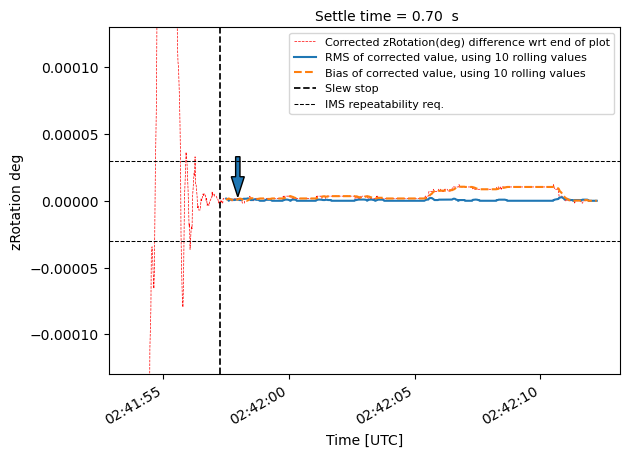

In [35]:
%matplotlib inline
# np.set_printoptions(threshold=sys.maxsize)
# pd.set_option("display.max_rows", None)
settle_intervals = np.empty(6)
c = 0

for col in all_columns:
    if col in pos_columns:
        req = req_rms_position
    else:
        req = req_rms_rotation
    settle_interval = computeSettleTime(
        df_ims=df_ims,
        referenceTime=t1,
        lo_delta_t=5,
        hi_delta_t=postPadding,
        imsColumn=col,
        rmsReq=req,
        req_delta_t=req_delta_t,
        chi2prob=0.99,
    )
    if settle_interval >= 0:
        print(f"{col} settled in {settle_interval:.2f} s")
    else:
        print(f"{col} not settled in {postPadding} s")
    settle_intervals[c] = settle_interval
    c = c + 1
avg = np.mean(settle_intervals[settle_intervals >= 0])
print(f"Average settling time is {avg:.2f} s")

In [ ]:
# this is an example call for a single column of the IMS data frame
computeSettleTime(
    df_ims=df_ims,
    referenceTime=t1,
    lo_delta_t=5,
    hi_delta_t=postPadding,
    imsColumn="zRotation",
    rmsReq=req_rms_rotation,
    req_delta_t=req_delta_t,
    chi2prob=0.999,
)